In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
import requests, json
from style_transfer_models import *
from preprocessing_utility import *


In [2]:
#VGG19 impementation
#https://towardsdatascience.com/creating-vgg-from-scratch-using-tensorflow-a998a5640155
#model_build: https://github.com/fchollet/deep-learning-models/blob/ccd0eb24996b4cbff4231b90cd44b057c0b20f14/vgg19.py#L30
model = VGG19_style_bottleneck()
# Display input images


2022-06-01 10:43:54.923818: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
url = requests.get("https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json")
text = url.text
classes = json.loads(text)

[[('n02980441', 'castle', 0.94969743),
  ('n03877845', 'palace', 0.023421504),
  ('n09332890', 'lakeside', 0.0053073904),
  ('n03028079', 'church', 0.0049058986),
  ('n02859443', 'boathouse', 0.0043468787)]]

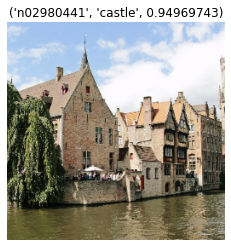

In [4]:
#CONTENT IMAGE
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
content_image = load_img(content_path)

preprocessed_content_image = preprocess_image(content_image, 256)
#preprocessed_content_image = tf.squeeze(preprocessed_content_image)
test_image = tf.image.resize(preprocessed_content_image, (224, 224))
test_image = tf.cast(test_image, tf.float32)
prediction_probabilities = model.predict(test_image*255)
plt.imshow(tf.squeeze(preprocessed_content_image))
plt.axis('off')
plt.title(decode_predictions(prediction_probabilities)[0][0])
decode_predictions(prediction_probabilities)





In [5]:
#for layer in model.layers:
#  print(layer.name)
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

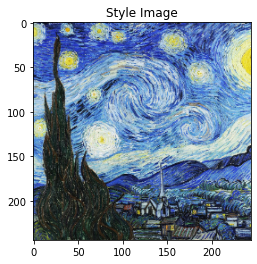

In [6]:
#Style path and image
style_path = tf.keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
#'/Users/clayolsen1/ML_folder/Style_transfering_NN/style_images/41176 copy.jpg'#tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')
style_image = load_img(style_path)
preprocessed_style_image = preprocess_image(style_image, 244)
#Extract style layers
style_extractor = model_layer_extraction(style_layers)
style_outputs = style_extractor(preprocessed_style_image*255)
imshow(preprocessed_style_image, 'Style Image')
#Look at the statistics of each layer's output
#for name, output in zip(style_layers, style_outputs):
#  print(name)
#  print("  shape: ", output.numpy().shape)
#  print("  min: ", output.numpy().min())
#  print("  max: ", output.numpy().max())
#  print("  mean: ", output.numpy().mean())
#  print()

### Calculate style
The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

This can be implemented concisely using the tf.linalg.einsum function:



In [7]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-8)
style_weight=1e-2
content_weight=1e4
constants = [style_targets, style_weight, num_style_layers, content_targets, content_weight, num_content_layers]

In [10]:
epochs = 100
image = tf.Variable(content_image)
total_loss = []
for n in range(epochs):
    
    total_loss.append(train_step(image, opt, extractor, constants))
    #end = time.time()
tensor_to_image(image)


KeyboardInterrupt: 

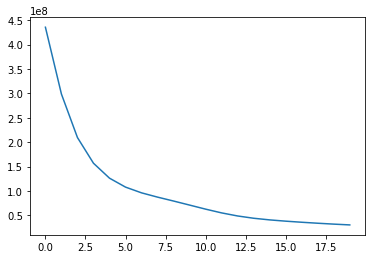

In [9]:
plt.plot(total_loss)
#48.7 w/out